In [4]:
!pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [26]:
dataset = pd.read_excel('SCFP2009panel.xlsx')

In [7]:
dataset.shape

(19285, 515)

In [8]:
# Data preparation and feature selection
# Computing Risky assets and risk-free assets for 2007
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07']\
 + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07']

# Computing Risky assets and risk-free assets for 2009
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09']\
+ dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09']

# Risk tolerance for 2007
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

In [9]:
# Average stock index for normalizing risky assets in 2009
Average_SP500_2007=1478
Average_SP500_2009=948

In [10]:
# 2009 risk tolerance
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

In [13]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Change in risk tolerance between 2007 and 2009
dataset['PercentageChange'] = np.abs(dataset['RT09']/dataset['RT07']-1)
dataset = dataset.dropna(axis=0)
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

<Axes: xlabel='RT07'>

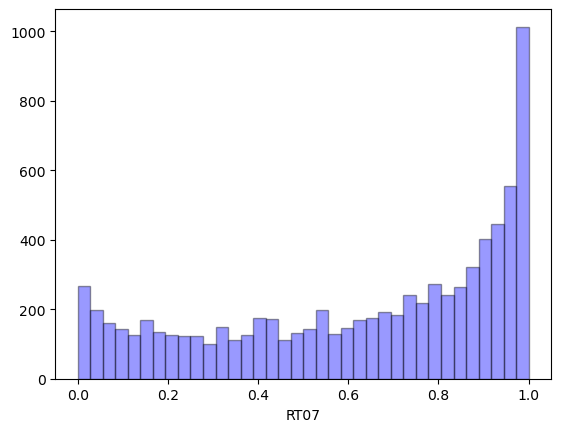

In [15]:
sns.distplot(dataset['RT07'], hist=True, kde=False, bins=int(180/5), color='blue', hist_kws={'edgecolor':'black'})


<Axes: xlabel='RT09'>

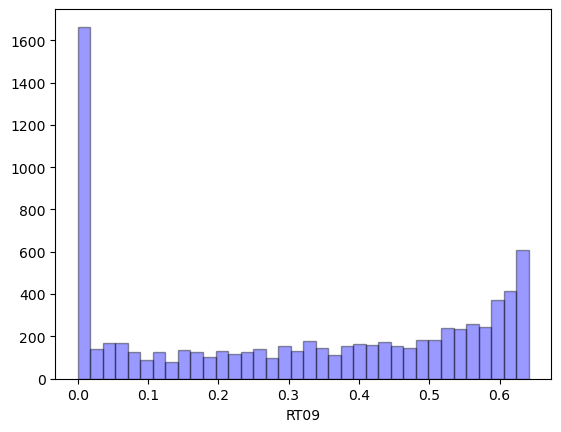

In [16]:
sns.distplot(dataset['RT09'], hist=True, kde=False, bins=int(180/5), color='blue', hist_kws={'edgecolor':'black'})


In [17]:
# Clearly, the behavior of the individuals reversed after the crisis.
# Overall risk tolerance decreased, which is shown by the outsized proportion of households having risk tolerance close to zero in 2009. 
# Most of the investments of these individuals were in risk-free assets.
# Picking intelligent investors whose tolerance didn't change
# tolerance between 2007 and 2009 was less than 10%

dataset3 = dataset[dataset['PercentageChange']<=.1]

In [18]:
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2

In [20]:
# Dropping unneccessary labels
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)

KeyError: "['RT07', 'RT09'] not found in axis"

In [21]:
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RiskFree09,Risky09,TrueRiskTolerance
60,14,141,13732.681713,77,6,12,2,1,0,6,...,12.956921,0.0,1000.080237,-35.900702,57,1.170225e+04,2.899673e+03,11000,5000,0.199511
425,95,951,43.840398,55,4,17,4,1,1,5,...,0.000000,0.0,-16.807607,-54.021909,57,1.102911e+06,2.226535e+06,1354500,30550000,0.641458
1122,253,2533,297.850586,85,6,17,4,1,0,5,...,18.876864,0.0,1061.195805,0.000000,57,2.148865e+06,3.075725e+06,70000,824000,0.589943
1190,270,2701,7184.506057,40,2,12,2,1,3,3,...,0.000000,0.0,19.213085,-100.000000,57,2.122975e+03,1.656956e+03,12300,25000,0.434127
1228,279,2794,4340.608277,70,5,12,2,1,0,5,...,127.436546,0.0,93.125197,-53.466186,57,1.788477e+05,5.488668e+04,331500,175000,0.228218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19190,4402,44021,5873.843391,53,3,16,4,1,0,2,...,0.000000,0.0,479.375591,13.545972,57,2.278315e+04,1.242717e+04,19000,23000,0.352094
19191,4402,44022,5939.807789,53,3,16,4,1,0,2,...,0.000000,0.0,479.375591,-9.418465,57,2.174755e+04,1.242717e+04,19000,23000,0.357442
19192,4402,44023,5970.026444,53,3,16,4,1,0,2,...,0.000000,0.0,479.375591,-18.158422,57,2.278315e+04,1.242717e+04,19000,23000,0.352094
19193,4402,44024,5993.081847,53,3,16,4,1,0,2,...,0.000000,0.0,479.375591,-21.165892,57,2.278315e+04,1.242717e+04,19000,23000,0.352094


In [23]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07',\
'RISK07','NETWORTH07','TrueRiskTolerance']

drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

In [24]:
# Correalation
correlation = dataset3.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

NameError: name 'plt' is not defined

<Axes: title={'center': 'Correlation Matrix'}>

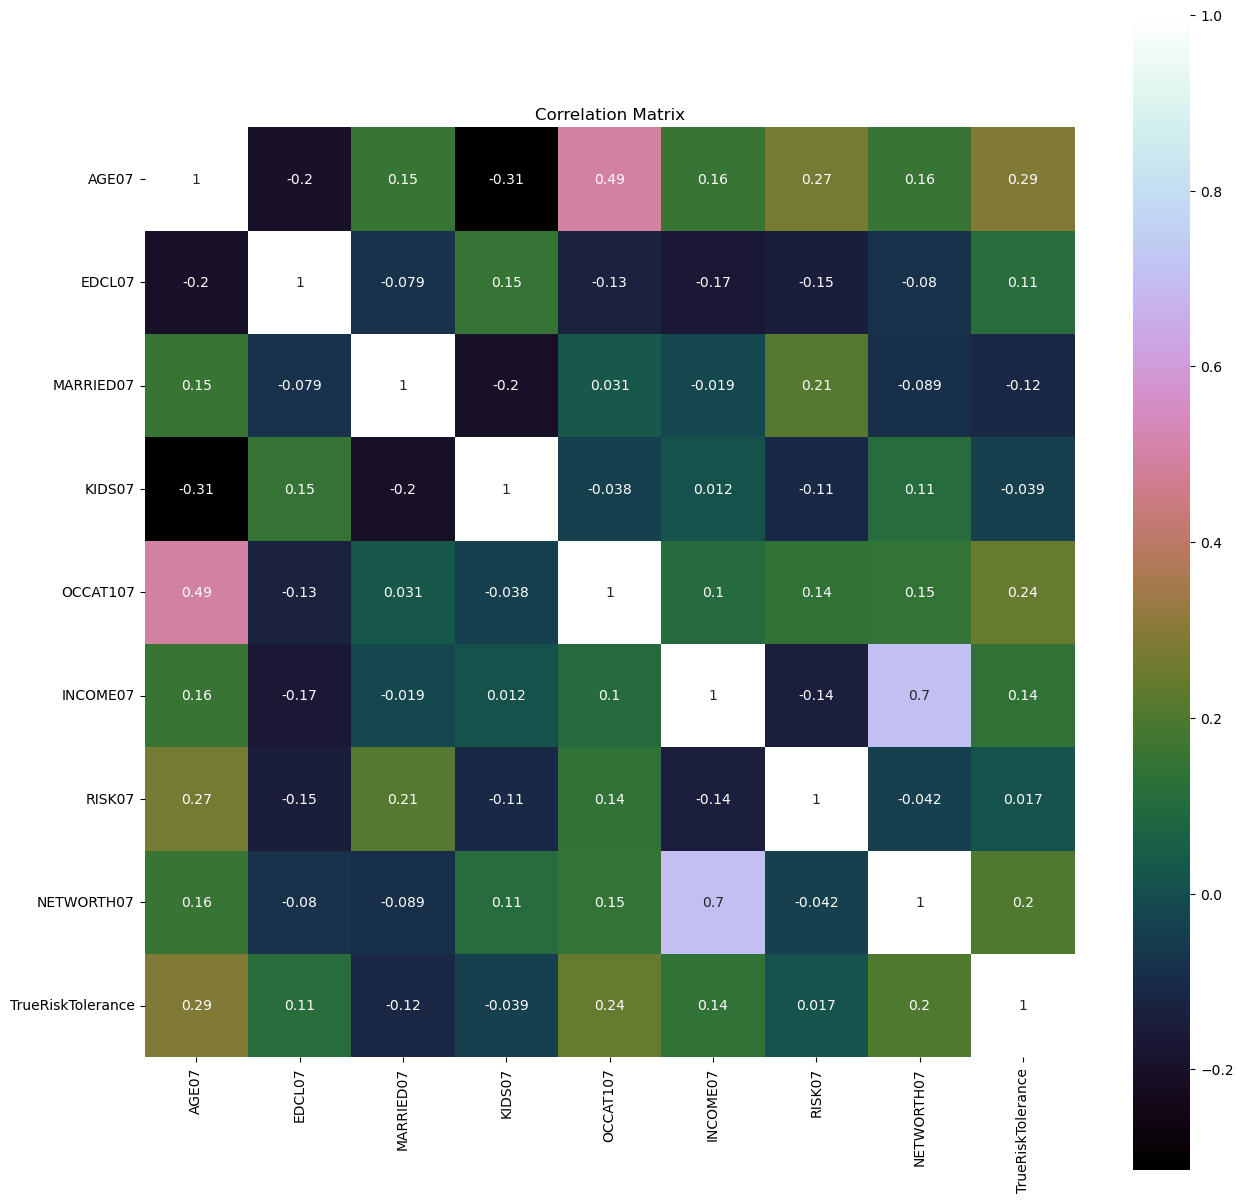

In [27]:
correlation = dataset3.corr()
pyplot.figure(figsize=(15,15))
pyplot.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

In [28]:
# Splitting train and test datasets
Y= dataset3["TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = \
train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [29]:
num_folds = 10
scoring = 'r2'

In [30]:
# spot-check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Ensemble Models
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [33]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds,shuffle=True,random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.102704 (0.179297)
LASSO: -0.041555 (0.109033)
EN: -0.047729 (0.108990)
KNN: -0.424571 (0.141433)
CART: -0.590303 (0.196284)
SVR: -0.127585 (0.101040)
ABR: -0.389904 (0.147673)
GBR: -0.622757 (0.138496)
RFR: -0.699875 (0.113090)
ETR: -0.692556 (0.147689)


In [34]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

NameError: name 'plt' is not defined

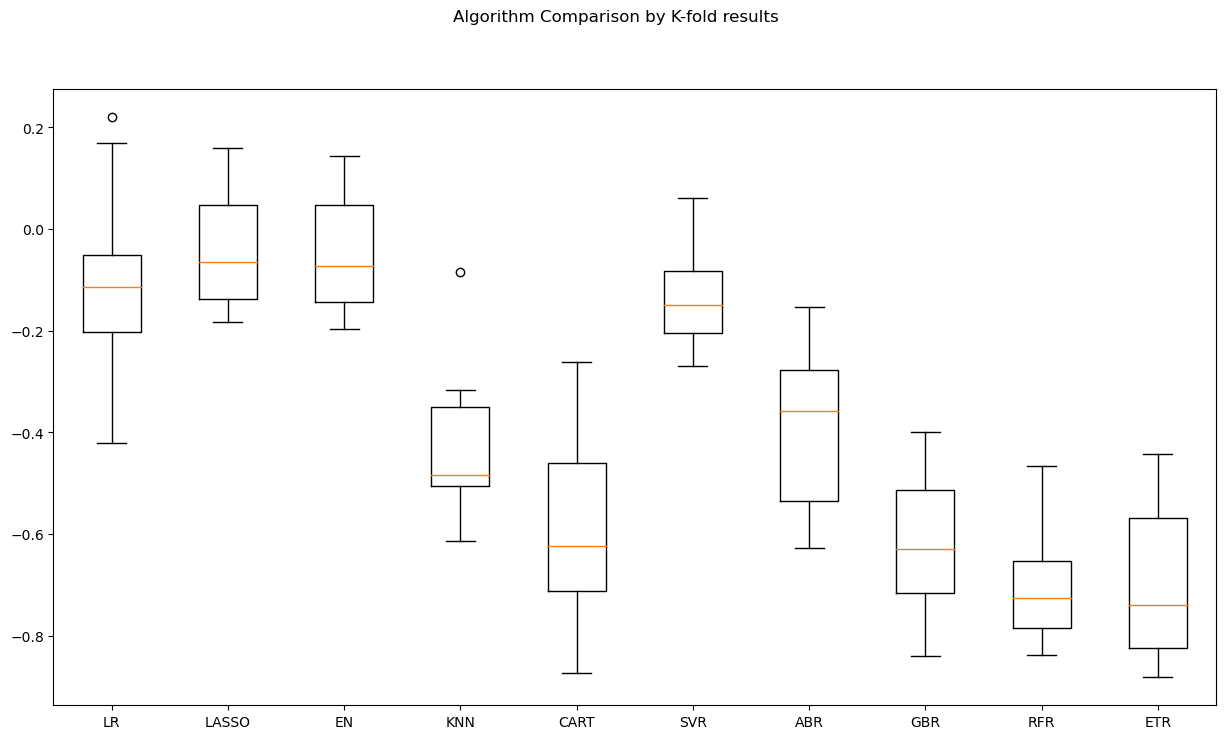

In [35]:
fig = pyplot.figure()
fig.suptitle("Algorithm Comparison by K-fold results")
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()

In [38]:
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds,shuffle=True,random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, \
  cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.718337 using {'n_estimators': 300}


In [61]:
model = RandomForestRegressor(n_estimators = 300)
model.fit(X_train, Y_train)
X_train, Y_train

(       AGE07  EDCL07  MARRIED07  KIDS07  OCCAT107      INCOME07  RISK07  \
 10233     54       4          1       4         2  3.812615e+06       1   
 18794     45       4          1       3         2  2.300349e+06       2   
 7786      80       2          1       0         2  1.159291e+08       2   
 3504      56       3          2       0         1  2.449446e+04       4   
 3090      58       4          1       1         1  1.150174e+05       2   
 ...      ...     ...        ...     ...       ...           ...     ...   
 14498     60       4          1       0         2  1.139525e+06       4   
 13941     42       3          1       0         2  1.810460e+05       3   
 7308      68       4          1       0         2  5.473978e+06       3   
 13565     65       4          1       0         2  1.331220e+05       2   
 8287      38       4          1       0         1  7.987322e+04       2   
 
          NETWORTH07  
 10233  1.489500e+07  
 18794  4.927891e+07  
 7786   2.828383e

In [41]:
from sklearn.metrics import r2_score

In [42]:
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.9632002222785074


In [43]:
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.0075394888753045125
0.768878699964259


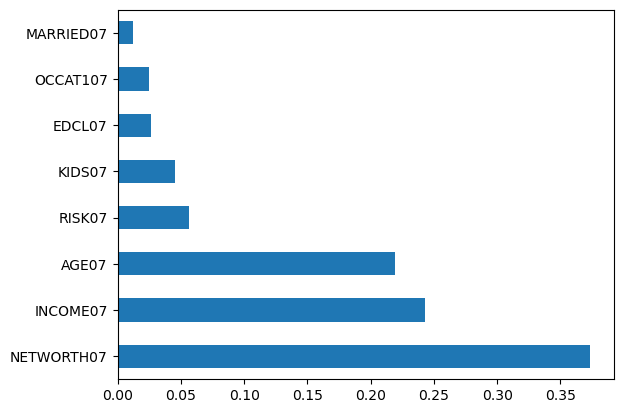

In [44]:
# Feature importance of the variables withtin the random forest model
import pandas as pd
import numpy as np
model = RandomForestRegressor(n_estimators= 200,n_jobs=-1)
model.fit(X_train,Y_train)
#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

In [45]:
from pickle import dump
from pickle import load

In [46]:
# save the model to disk
filename = 'finalized_robo_advice_model.sav'
dump(model, open(filename, 'wb'))

In [47]:
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
predictions = loaded_model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(r2_score(Y_validation, predictions))
print(result)

0.7705951606768497
0.00748349560923395


In [49]:
# Robo advisor Section
investors = pd.read_csv('InputData.csv', index_col = 0 )
investors.head()

,AGE07,EDCL07,MARRIED07,KIDS07,LIFECL07,OCCAT107,INCOME07,RISK07,WSAVED07,SPENDMOR07,NETWORTH07,TrueRiskTol
0,47,2,1,0,2,1,56443.744181,3,1,5,352641.71130,6.947439
1,47,2,1,0,2,1,56443.744181,3,1,5,340525.21881,6.223158
2,47,2,1,0,2,1,56443.744181,3,1,5,348696.08426,6.676709
3,47,2,1,0,2,1,56443.744181,3,1,5,351802.87720,6.286854
4,47,2,1,0,2,1,56443.744181,3,1,5,358958.85696,6.177016


In [57]:
assets = pd.read_csv('SP500Data.csv',index_col=0)
missing_fractions = assets.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

assets.drop(labels=drop_list, axis=1, inplace=True)
assets.shape
# Fill the missing values with the last value available in the dataset. 
assets=assets.fillna(method='ffill')
assets.head(2)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998


In [58]:
options=np.array(assets.columns)
# str(options)
options = []

for tic in assets.columns:
    #{'label': 'user sees', 'value': 'script sees'}
    mydict = {}
    mydict['label'] = tic #Apple Co. AAPL
    mydict['value'] = tic
    options.append(mydict)

In [52]:
def predict_risk_tolerance(X_input):
    filename = 'finalized_robo_advice_model.sav'
    loaded_model = load(open(filename, 'rb'))
    predictions = loaded_model.predict(X_input)
    return predictions

def get_asset_allocation(riskTolerance, stock_ticker):
    assets_selected = assets.loc[:, stock_ticker]
    return_vec = np.array(assets_selected.pct_change().dropna(axis=0)).T
    n = len(return_vec)
    returns = np.asmatrix(return_vec)
    mus = 1 - riskTolerance
    
    S = opt.matrix(np.cov(return_vec))
    pbar = opt.matrix(np.mean(return_vec, axis=1))
    # Constraint matrices
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    # Calculate efficient frontier weights using quadratic programming
    portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
    w=portfolios['x'].T
    print (w)
    Alloc =  pd.DataFrame(data = np.array(portfolios['x']),index = assets_selected.columns)
    # Calculate efficient frontier weights using quadratic programming
    portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
    returns_final=(np.array(assets_selected) * np.array(w))
    returns_sum = np.sum(returns_final,axis =1)
    returns_sum_pd = pd.DataFrame(returns_sum, index = assets.index )
    returns_sum_pd = returns_sum_pd - returns_sum_pd.iloc[0,:] + 100   
    return Alloc,returns_sum_pd
    

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SP500: No timezone found, symbol may be delisted


In [54]:
def update_risk_tolerance(n_clicks,Age,Nwcat,Inccl,Risk,Edu,Married,Kids,Occ):
      
    #ipdb.set_trace()
    
    RiskTolerance = 0
    if n_clicks != None:    
        X_input = [[Age,Edu,Married,Kids,Occ,Inccl, Risk,Nwcat]]
        RiskTolerance= predict_riskTolerance(X_input)
    #print(RiskAversion)
    #Using linear regression to get the risk tolerance within the cluster.    
    return list([round(float(RiskTolerance*100),2)])



In [55]:
# Creating graphs for allocation
def update_asset_allocationChart(n_clicks, risk_tolerance, stock_ticker):
    
    Allocated, InvestmentReturn = get_asset_allocation(risk_tolerance,stock_ticker)  
    
    return [{'data' : [go.Bar(
                        x=Allocated.index,
                        y=Allocated.iloc[:,0],
                        marker=dict(color='red'),
                    ),
                    ],
            'layout': {'title':" Asset allocation - Mean-Variance Allocation"}

       },
            {'data' : [go.Scatter(
                        x=InvestmentReturn.index,
                        y=InvestmentReturn.iloc[:,0],
                        name = 'OEE (%)',
                        marker=dict(color='red'),
                    ),
                    ],
            'layout': {'title':"Portfolio value of $100 investment"}

       }]

,SP500
DATE,
2018-05-03,2629.73
2018-05-04,2663.42
2018-05-07,2672.63
2018-05-08,2671.92
2018-05-09,2697.79
...,...
2023-04-25,4071.63
2023-04-26,4055.99
2023-04-27,4135.35
